<a href="https://www.kaggle.com/code/tammysilva/phys243-final-project-jiaxin-tang-box-office-pred?scriptVersionId=92857874" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tmdbboxofficeprediction/sample_submission.csv
/kaggle/input/tmdbboxofficeprediction/train.csv
/kaggle/input/tmdbboxofficeprediction/test.csv


# 0 Summary
### I applied all I have learned in the 'Foundation of Applied Machine Learning' course to this final project. It definely helps me to refresh most of the knowledge and techniques in the ML field. What I did are as follows.
1. Load packages and Load Data
2. Exploratory Data Analysis
3. Data cleaning and feature engineering
4. Data scaling and spliting
5. Model Training with Stochastic Gradient Descent, Random Foreset and XGBoost
6. Model Evaluation
7. Conclusion

# 1 Load Packages and Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import re

import sklearn.preprocessing as preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv("../input/tmdbboxofficeprediction/sample_submission.csv")
test_df = pd.read_csv("../input/tmdbboxofficeprediction/test.csv")
train_df = pd.read_csv("../input/tmdbboxofficeprediction/train.csv")

# 2 Exploratory Data Analysis
## 2.1 Exclude erroneous data

In [4]:
if train_df['id'].duplicated().sum()==0:
  print('no duplicated index')

no duplicated index


## 2.2 Overview

In [5]:
df.head(3)

,id,revenue
0,3001,1000000
1,3002,1000000
2,3003,1000000


In [6]:
train_df.head(3)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4398 entries, 0 to 4397
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4398 non-null   int64  
 1   belongs_to_collection  877 non-null    object 
 2   budget                 4398 non-null   int64  
 3   genres                 4382 non-null   object 
 4   homepage               1420 non-null   object 
 5   imdb_id                4398 non-null   object 
 6   original_language      4398 non-null   object 
 7   original_title         4398 non-null   object 
 8   overview               4384 non-null   object 
 9   popularity             4398 non-null   float64
 10  poster_path            4397 non-null   object 
 11  production_companies   4140 non-null   object 
 12  production_countries   4296 non-null   object 
 13  release_date           4397 non-null   object 
 14  runtime                4394 non-null   float64
 15  spok

In [9]:
train_df.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [10]:
train_df.nunique()

id                       3000
belongs_to_collection     422
budget                    406
genres                    872
homepage                  941
imdb_id                  3000
original_language          36
original_title           2975
overview                 2992
popularity               2999
poster_path              2999
production_companies     2383
production_countries      321
release_date             2398
runtime                   139
spoken_languages          401
status                      2
tagline                  2400
title                    2969
Keywords                 2648
cast                     2975
crew                     2984
revenue                  2850
dtype: int64

In [11]:
print(train_df.describe(percentiles=[0.1,0.25,0.5,0.75,0.95]))
(train_df==0).sum(axis=0)/train_df.shape[0]

                id        budget   popularity      runtime       revenue
count  3000.000000  3.000000e+03  3000.000000  2998.000000  3.000000e+03
mean   1500.500000  2.253133e+07     8.463274   107.856571  6.672585e+07
std     866.169729  3.702609e+07    12.104000    22.086434  1.375323e+08
min       1.000000  0.000000e+00     0.000001     0.000000  1.000000e+00
10%     300.900000  0.000000e+00     1.298088    87.000000  1.729354e+05
25%     750.750000  0.000000e+00     4.018053    94.000000  2.379808e+06
50%    1500.500000  8.000000e+06     7.374861   104.000000  1.680707e+07
75%    2250.250000  2.900000e+07    10.890983   118.000000  6.891920e+07
95%    2850.050000  9.500000e+07    16.839314   147.000000  3.012438e+08
max    3000.000000  3.800000e+08   294.337037   338.000000  1.519558e+09


id                       0.000000
belongs_to_collection    0.000000
budget                   0.270667
genres                   0.000000
homepage                 0.000000
imdb_id                  0.000000
original_language        0.000000
original_title           0.000000
overview                 0.000000
popularity               0.000000
poster_path              0.000000
production_companies     0.000000
production_countries     0.000000
release_date             0.000000
runtime                  0.004000
spoken_languages         0.000000
status                   0.000000
tagline                  0.000000
title                    0.000000
Keywords                 0.000000
cast                     0.000000
crew                     0.000000
revenue                  0.000000
dtype: float64

Text(0, 0.5, 'density')

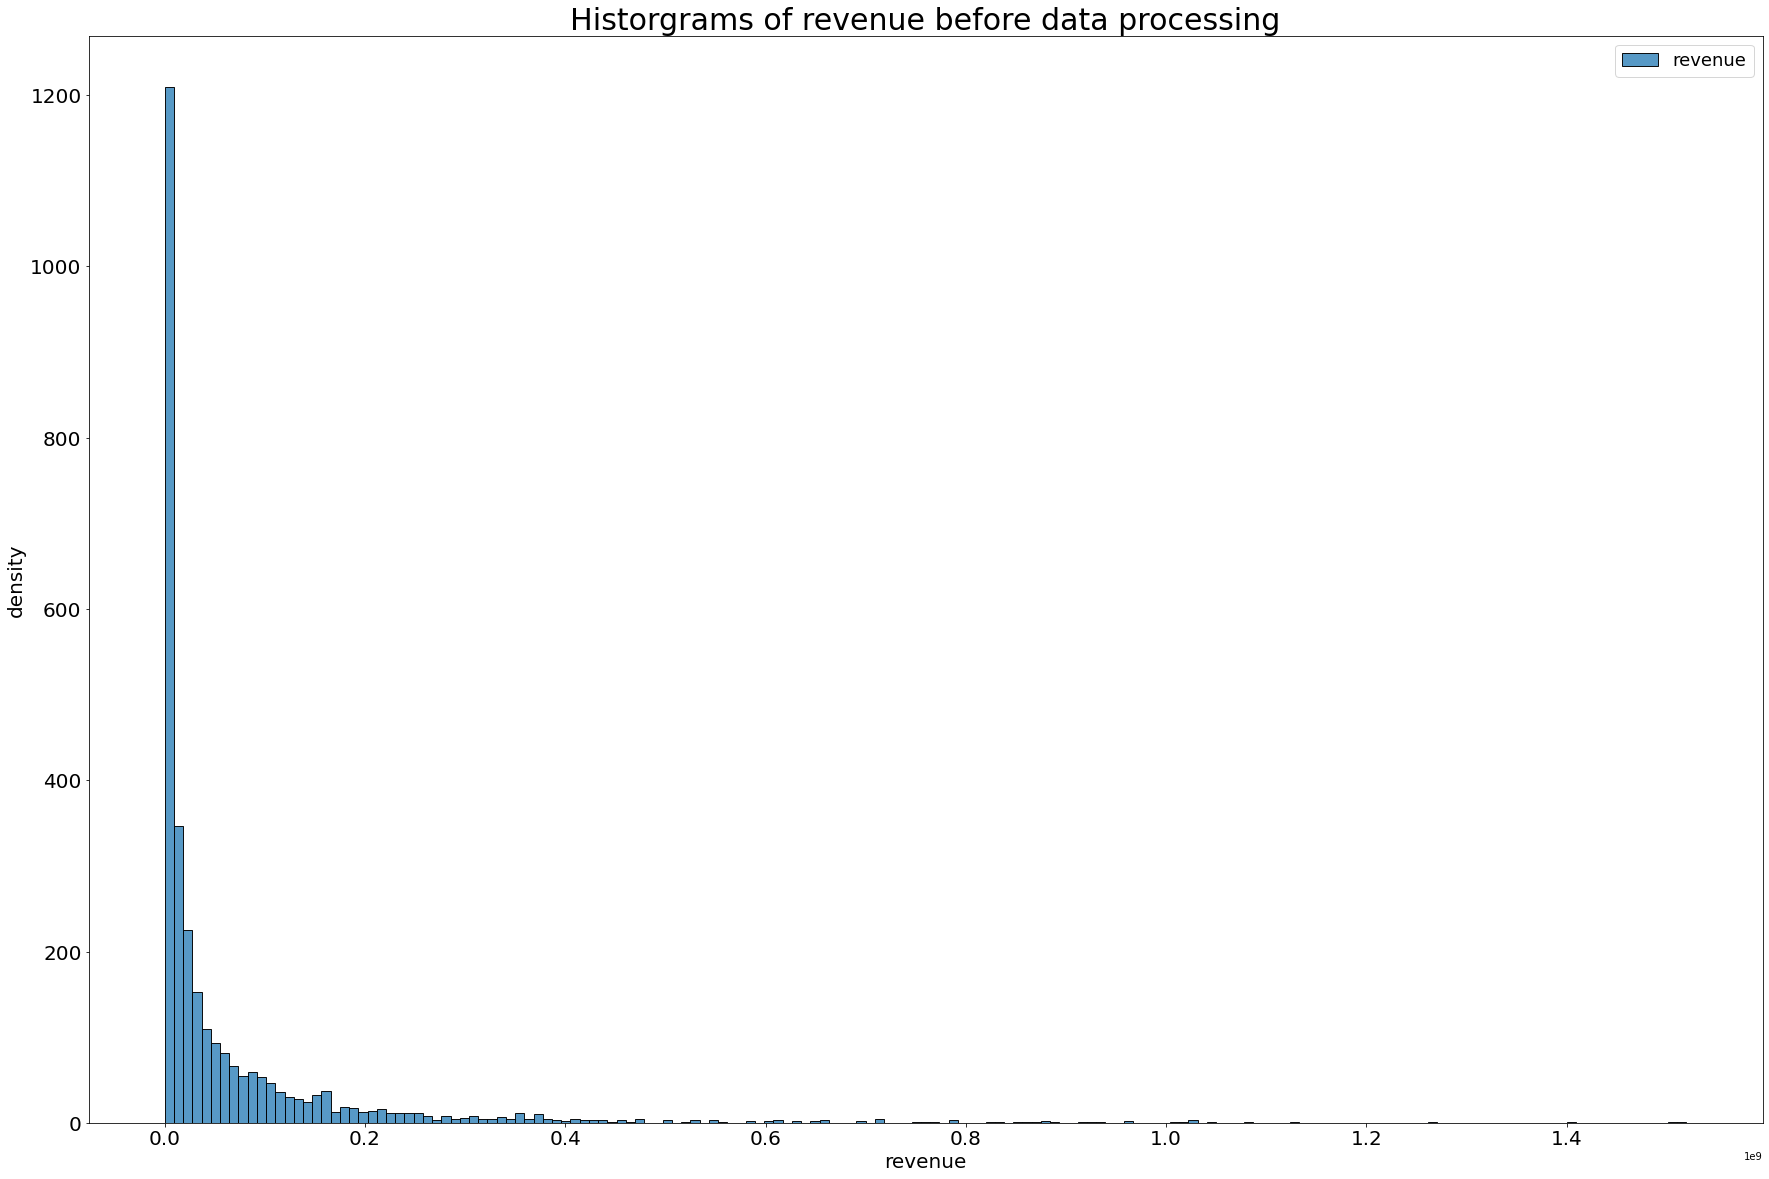

In [12]:
# Distribution of the target label - 'revenue'
_,axss = plt.subplots(1,1, figsize=[30,20])
sns.histplot(x="revenue",data=train_df)
plt.legend(labels=["revenue"],fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Historgrams of revenue before data processing',fontsize=30)
plt.xlabel('revenue',fontsize=20)
plt.ylabel('density',fontsize=20)

### After very basic Exploratory Data Analysis, I have to do some data cleaning and feature engineering. I need three steps to finish this. First, I need to go through each feature one by one. Second, I need to drop the unusable and duplicated features. Third, I need to impute the missing value for both numeric and categorical feature.impute the missing value for both numeric and categorical features. Then I can scale out features, which can be better for our models' performance.

# 3 Data cleaning and feature engineering
## 3.1 belongs_to_collection 

In [13]:
for i in range(10):
    print(train_df.belongs_to_collection[i])

[{'id': 313576, 'name': 'Hot Tub Time Machine Collection', 'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg', 'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]
[{'id': 107674, 'name': 'The Princess Diaries Collection', 'poster_path': '/wt5AMbxPTS4Kfjx7Fgm149qPfZl.jpg', 'backdrop_path': '/zSEtYD77pKRJlUPx34BJgUG9v1c.jpg'}]
nan
nan
nan
nan
nan
nan
[{'id': 256377, 'name': 'The Muppet Collection', 'poster_path': '/8Ew8EIdFFurMMYjSbWPu1Hl4vLX.jpg', 'backdrop_path': '/1AWd3MM90G47mxtD112gRDxSXY9.jpg'}]
nan


In [14]:
# I think only the name of this feature matters, which is the same as the 'original_title'. Also, it contains 2396 null values. So I drop this feature.
train_df.drop(['belongs_to_collection'], axis=1, inplace=True)

## 3.2 budget

In [15]:
train_df.budget[:10]

0    14000000
1    40000000
2     3300000
3     1200000
4           0
5     8000000
6    14000000
7           0
8           0
9     6000000
Name: budget, dtype: int64

In [16]:
# The 'budget' column contains lots of 0s, which are considered as missing values. It affects the mean value of the 'budget' feature. So I replace them with the median.
train_df.budget = train_df.budget.replace(0,train_df.budget.median())
train_df.budget[:10]

0    14000000
1    40000000
2     3300000
3     1200000
4     8000000
5     8000000
6    14000000
7     8000000
8     8000000
9     6000000
Name: budget, dtype: int64

In [17]:
# Correlation with 'revenue'
train_df.budget.corr(train_df.revenue)

0.7534899073290289

<AxesSubplot:xlabel='budget', ylabel='Density'>

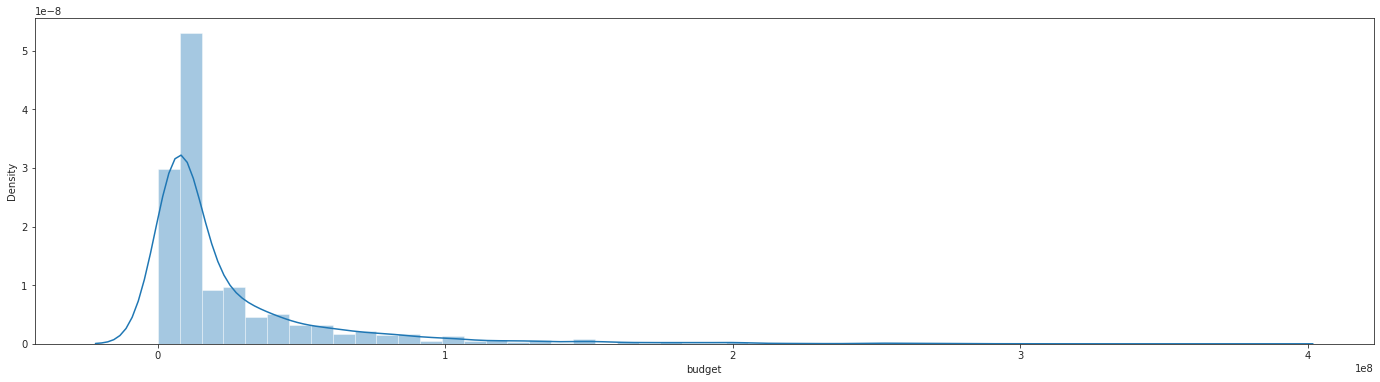

In [18]:
# Distribution of 'budget'
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(24,6)
sns.distplot(train_df.budget)

## 3.3 genres

In [19]:
for i in range(10):
    print(train_df.genres[i])

[{'id': 35, 'name': 'Comedy'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'name': 'Drama'}, {'id': 10751, 'name': 'Family'}, {'id': 10749, 'name': 'Romance'}]
[{'id': 18, 'name': 'Drama'}]
[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'name': 'Drama'}]
[{'id': 28, 'name': 'Action'}, {'id': 53, 'name': 'Thriller'}]
[{'id': 16, 'name': 'Animation'}, {'id': 12, 'name': 'Adventure'}, {'id': 10751, 'name': 'Family'}]
[{'id': 27, 'name': 'Horror'}, {'id': 53, 'name': 'Thriller'}]
[{'id': 99, 'name': 'Documentary'}]
[{'id': 28, 'name': 'Action'}, {'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}, {'id': 10751, 'name': 'Family'}, {'id': 12, 'name': 'Adventure'}]
[{'id': 35, 'name': 'Comedy'}, {'id': 10402, 'name': 'Music'}]


In [20]:
# Define get_dict function
def get_dict(s):
    try:
        d = eval(s)
    except:
        d = {}
    return d

In [21]:
# Convert 'genres' into dummy variables
train_df['genres_name'] = train_df['genres'].apply(lambda x: sorted([d['name'] for d in get_dict(x)])).apply(lambda x: ','.join(x))

genres = train_df.genres_name.str.get_dummies(sep=',')
genres.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [22]:
# Concatenate to the train_df
train_df = pd.concat([train_df, genres], axis =1)

## 3.4 original_language

In [23]:
train_df.original_language[:5]

0    en
1    en
2    en
3    hi
4    ko
Name: original_language, dtype: object

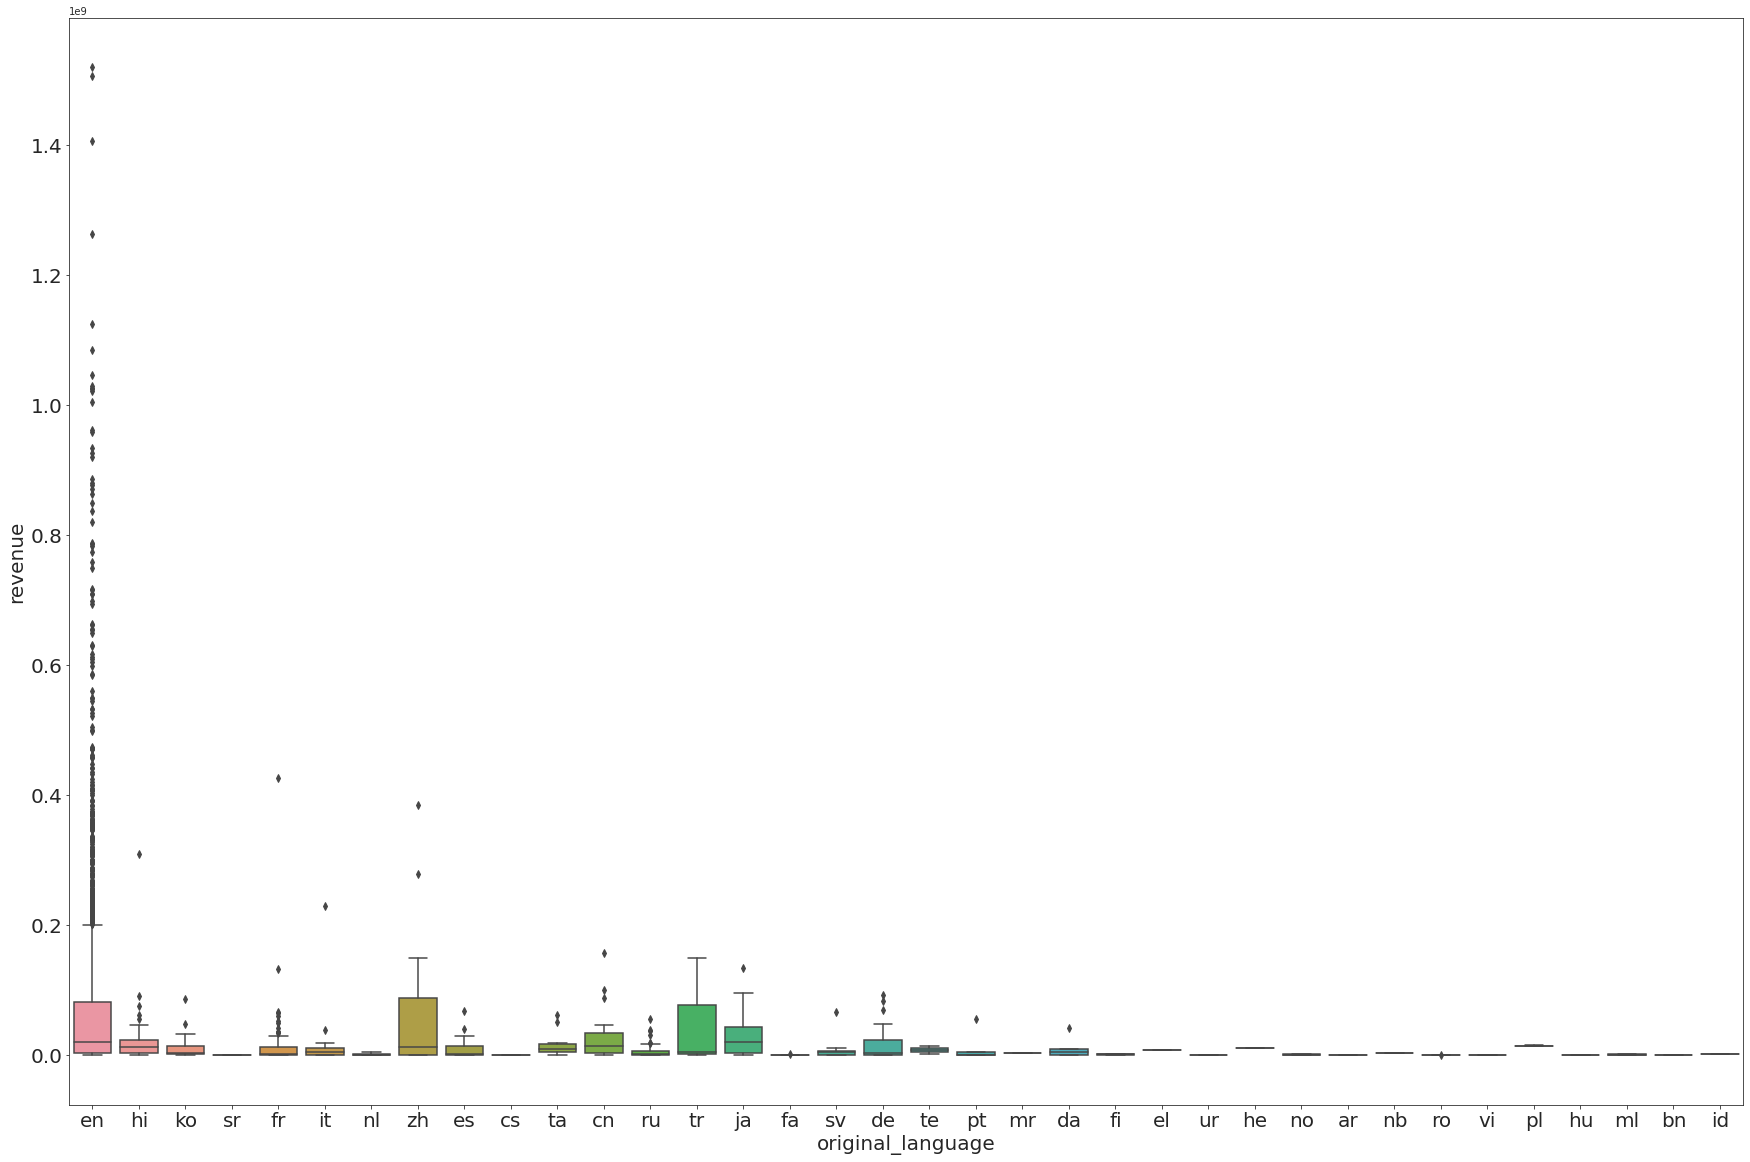

en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
cn      20
ko      20
zh      19
de      18
ta      16
sv       8
nl       6
pt       6
fa       5
da       5
ro       4
hu       3
tr       3
no       2
ml       2
pl       2
te       2
fi       2
ur       1
he       1
el       1
ar       1
nb       1
vi       1
mr       1
cs       1
sr       1
bn       1
id       1
Name: original_language, dtype: int64


In [24]:
# Boxplot of 'original_language'
_,axss = plt.subplots(1,1, figsize=[30,20])
sns.boxplot(x='original_language', y='revenue', data=train_df)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('original_language',fontsize=20)
plt.ylabel('revenue',fontsize=20)
plt.show()
print(train_df['original_language'].value_counts())

In [25]:
j = 0
for i in train_df['original_language']:
    if i == 'en':
        train_df['original_language'][j] = 'en'
    else:
        train_df['original_language'][j] = 'others'
    j += 1

In [26]:
train_df.original_language[:5]

0        en
1        en
2        en
3    others
4    others
Name: original_language, dtype: object

## 3.5 original_title

In [27]:
train_df.original_title[:10]

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                        마린보이
5      Pinocchio and the Emperor of the Night
6                              The Possession
7                                Control Room
8                      Muppet Treasure Island
9                               A Mighty Wind
Name: original_title, dtype: object

In [28]:
# The length of the 'original_title' seems to have an impact
train_df['original_title_len'] = train_df.original_title.apply(lambda x: len(x))
train_df.original_title_len

0       22
1       40
2        8
3        7
4        4
        ..
2995     7
2996    11
2997    23
2998    16
2999     9
Name: original_title_len, Length: 3000, dtype: int64

<AxesSubplot:xlabel='original_title_len', ylabel='Density'>

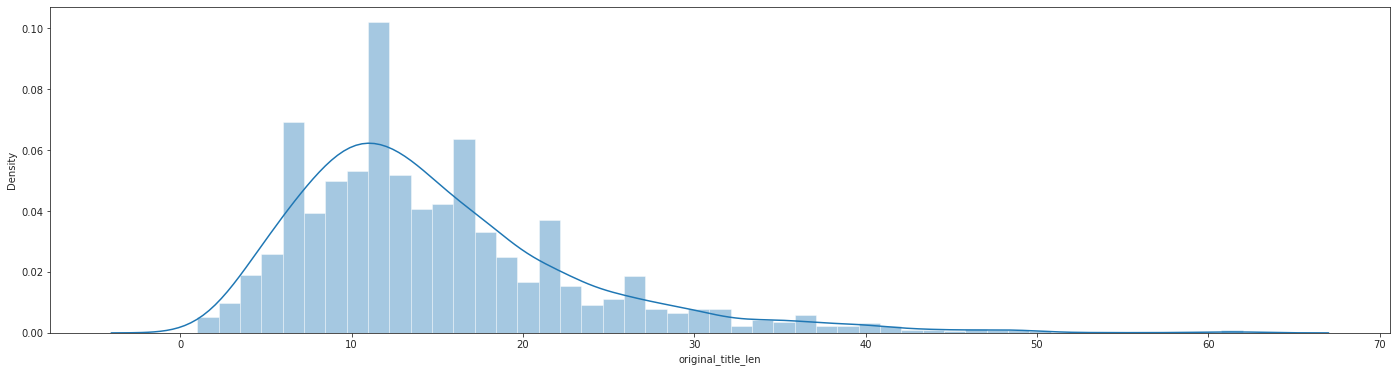

In [29]:
# Distribution of the 'original_title_len'
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(24,6)
sns.distplot(train_df.original_title_len)

Text(0.5, 0, 'original_title_len')

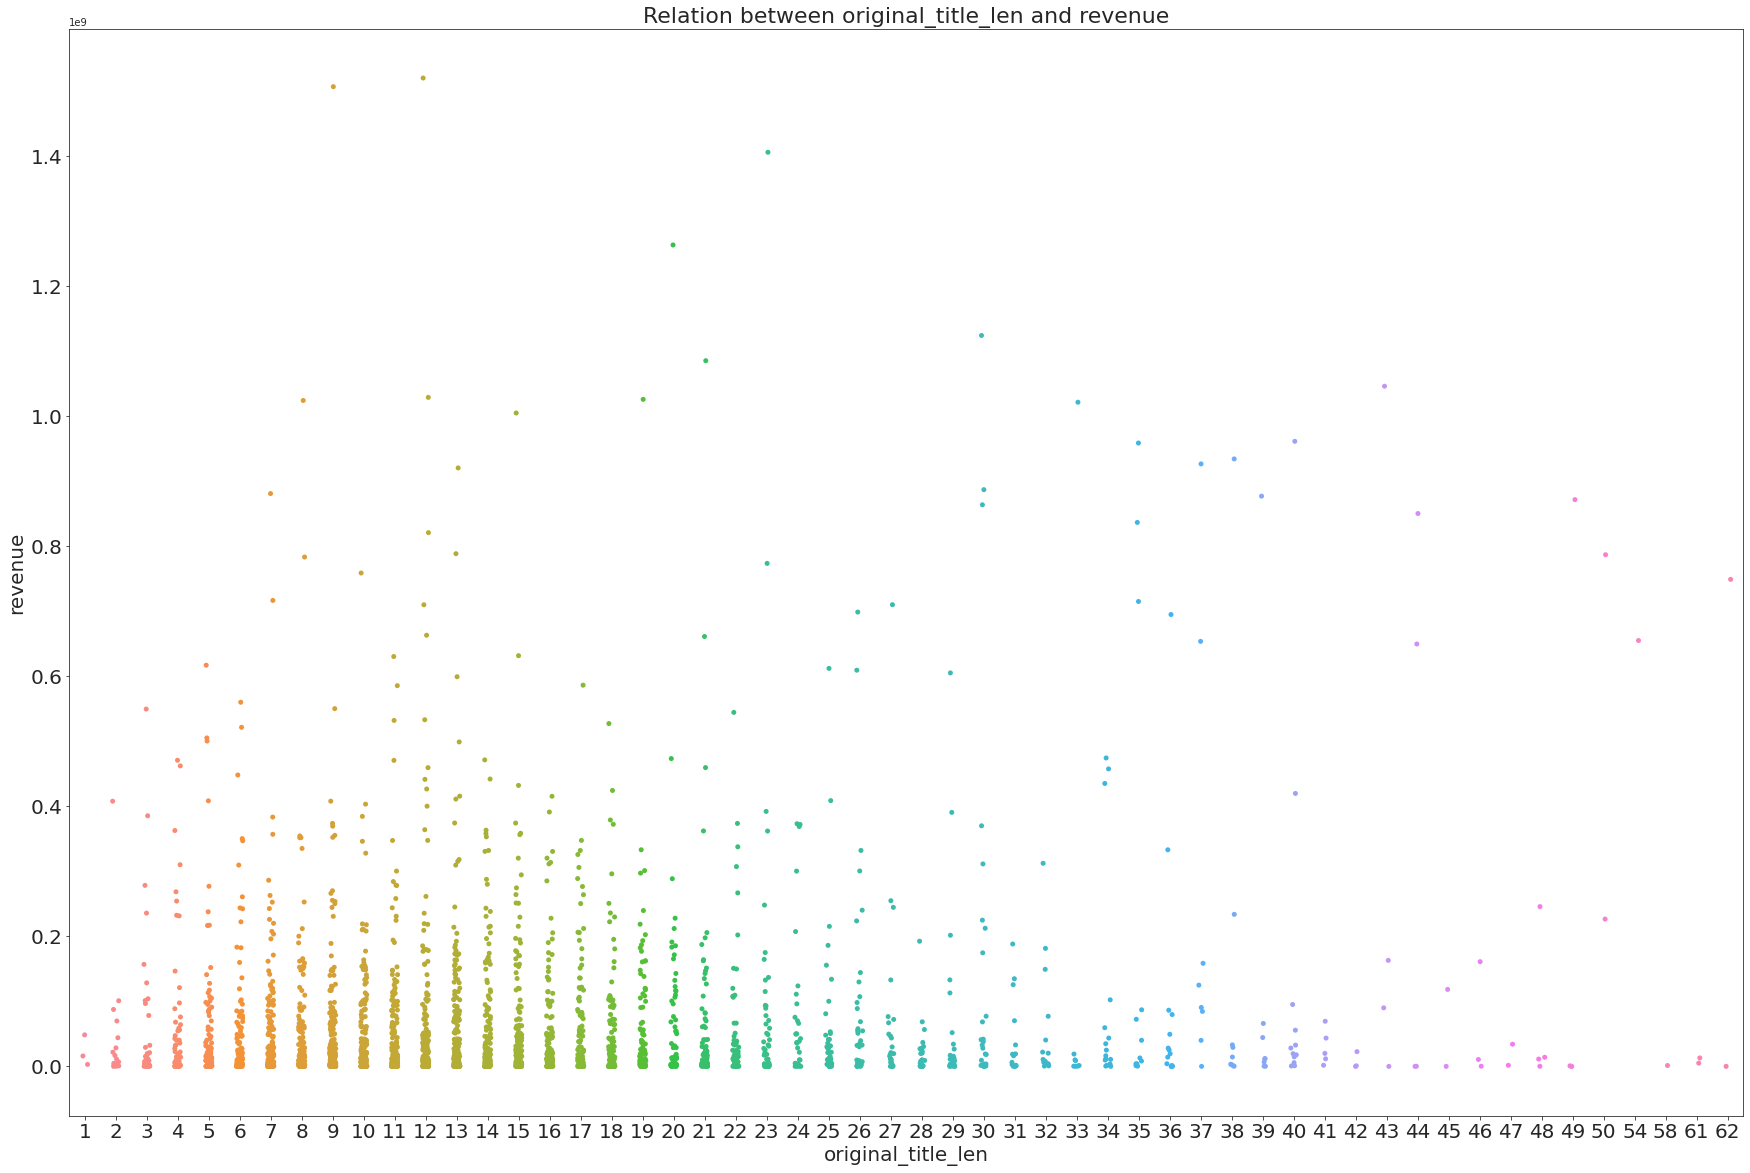

In [30]:
# Relation between 'original_title_len' and 'revenue'
_,axss = plt.subplots(1,1, figsize=[30,20])
sns.stripplot(x='original_title_len', y='revenue', data=train_df)
plt.title('Relation between original_title_len and revenue',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('revenue',fontsize=20)
plt.xlabel('original_title_len',fontsize=20)

## 3.6 production_companies

In [31]:
for i in range(5):
    print(train_df.production_companies[i])

[{'name': 'Paramount Pictures', 'id': 4}, {'name': 'United Artists', 'id': 60}, {'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8411}]
[{'name': 'Walt Disney Pictures', 'id': 2}]
[{'name': 'Bold Films', 'id': 2266}, {'name': 'Blumhouse Productions', 'id': 3172}, {'name': 'Right of Way Films', 'id': 32157}]
nan
nan


In [32]:
# The numbers of the 'production_companies' for the movies seems to have an impact
num_prod_com = pd.DataFrame(columns=['num_production_companies'])
train_df = pd.concat([train_df, num_prod_com], axis=1)

In [33]:
j = 0
for i in train_df['production_companies']:
    d = get_dict(i)
    if len(d) != 0:
        train_df['num_production_companies'][j] = len(d)
    else:
        train_df['num_production_companies'][j] = np.NaN
    j += 1

In [34]:
train_df.num_production_companies[:5]

0      3
1      1
2      3
3    NaN
4    NaN
Name: num_production_companies, dtype: object

Text(0.5, 0, 'num_production_companies')

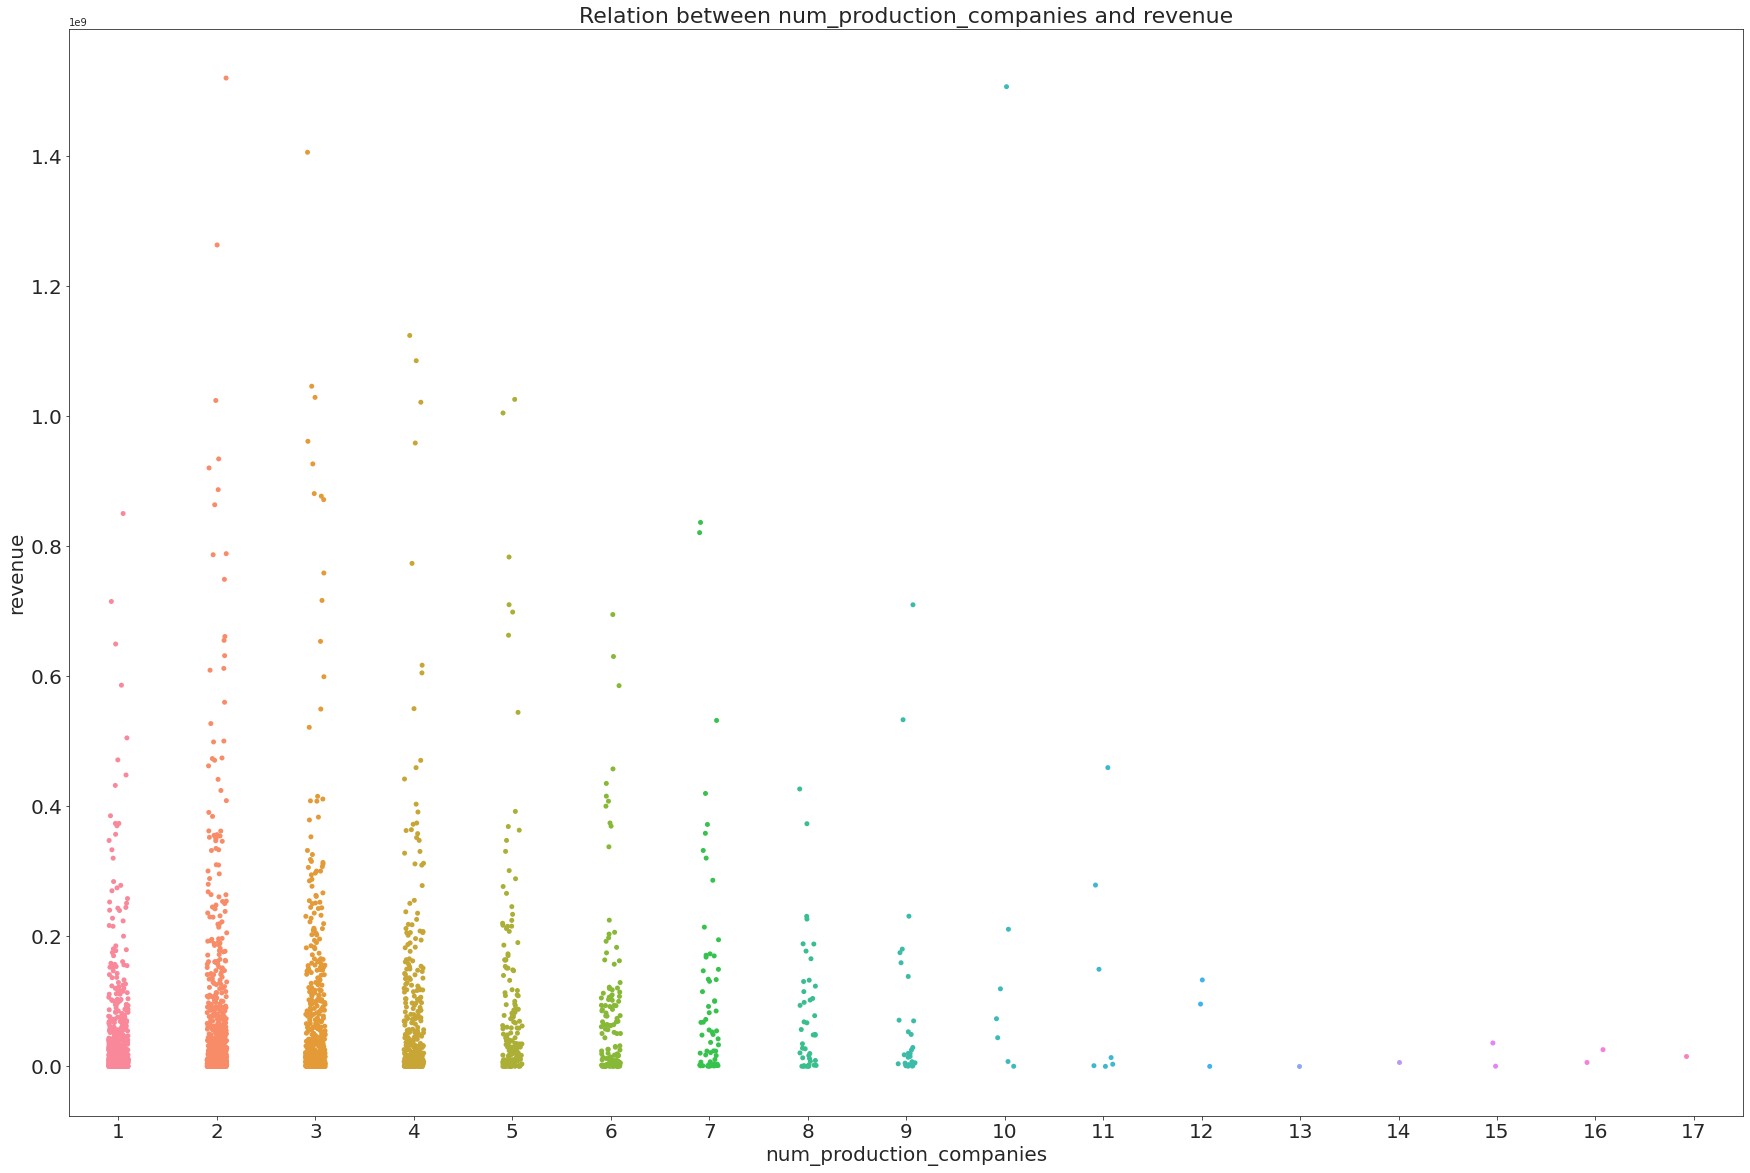

In [35]:
# Relation between 'num_production_companies' and 'revenue'
_,axss = plt.subplots(1,1, figsize=[30,20])
sns.stripplot(x='num_production_companies', y='revenue', data=train_df)
plt.title('Relation between num_production_companies and revenue',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('revenue',fontsize=20)
plt.xlabel('num_production_companies',fontsize=20)

## 3.7 production_countries

In [36]:
for i in range(5):
    print(train_df.production_countries[i])

[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'US', 'name': 'United States of America'}]
[{'iso_3166_1': 'IN', 'name': 'India'}]
[{'iso_3166_1': 'KR', 'name': 'South Korea'}]


In [37]:
# Extract the name of each countries and add them to a new column
prod_country = pd.DataFrame(columns=['production_country'])
train_df = pd.concat([train_df, prod_country], axis=1)

In [38]:
j = 0
for i in train_df['production_countries']:
    d = get_dict(i)
    if d != {}:
        if len(d) > 1:
            countires = []
            for k in range(len(d)):
                countires.append(d[k]['name'])
            if 'United States of America' in countires:
                train_df['production_country'][j] = 'United States of America'
        else:
            train_df['production_country'][j] = d[0]['name']
    else:
        train_df['production_country'][j] = np.NaN
    j += 1

In [39]:
train_df.production_country[:5]

0    United States of America
1    United States of America
2    United States of America
3                       India
4                 South Korea
Name: production_country, dtype: object

Text(0.5, 0, 'production_country')

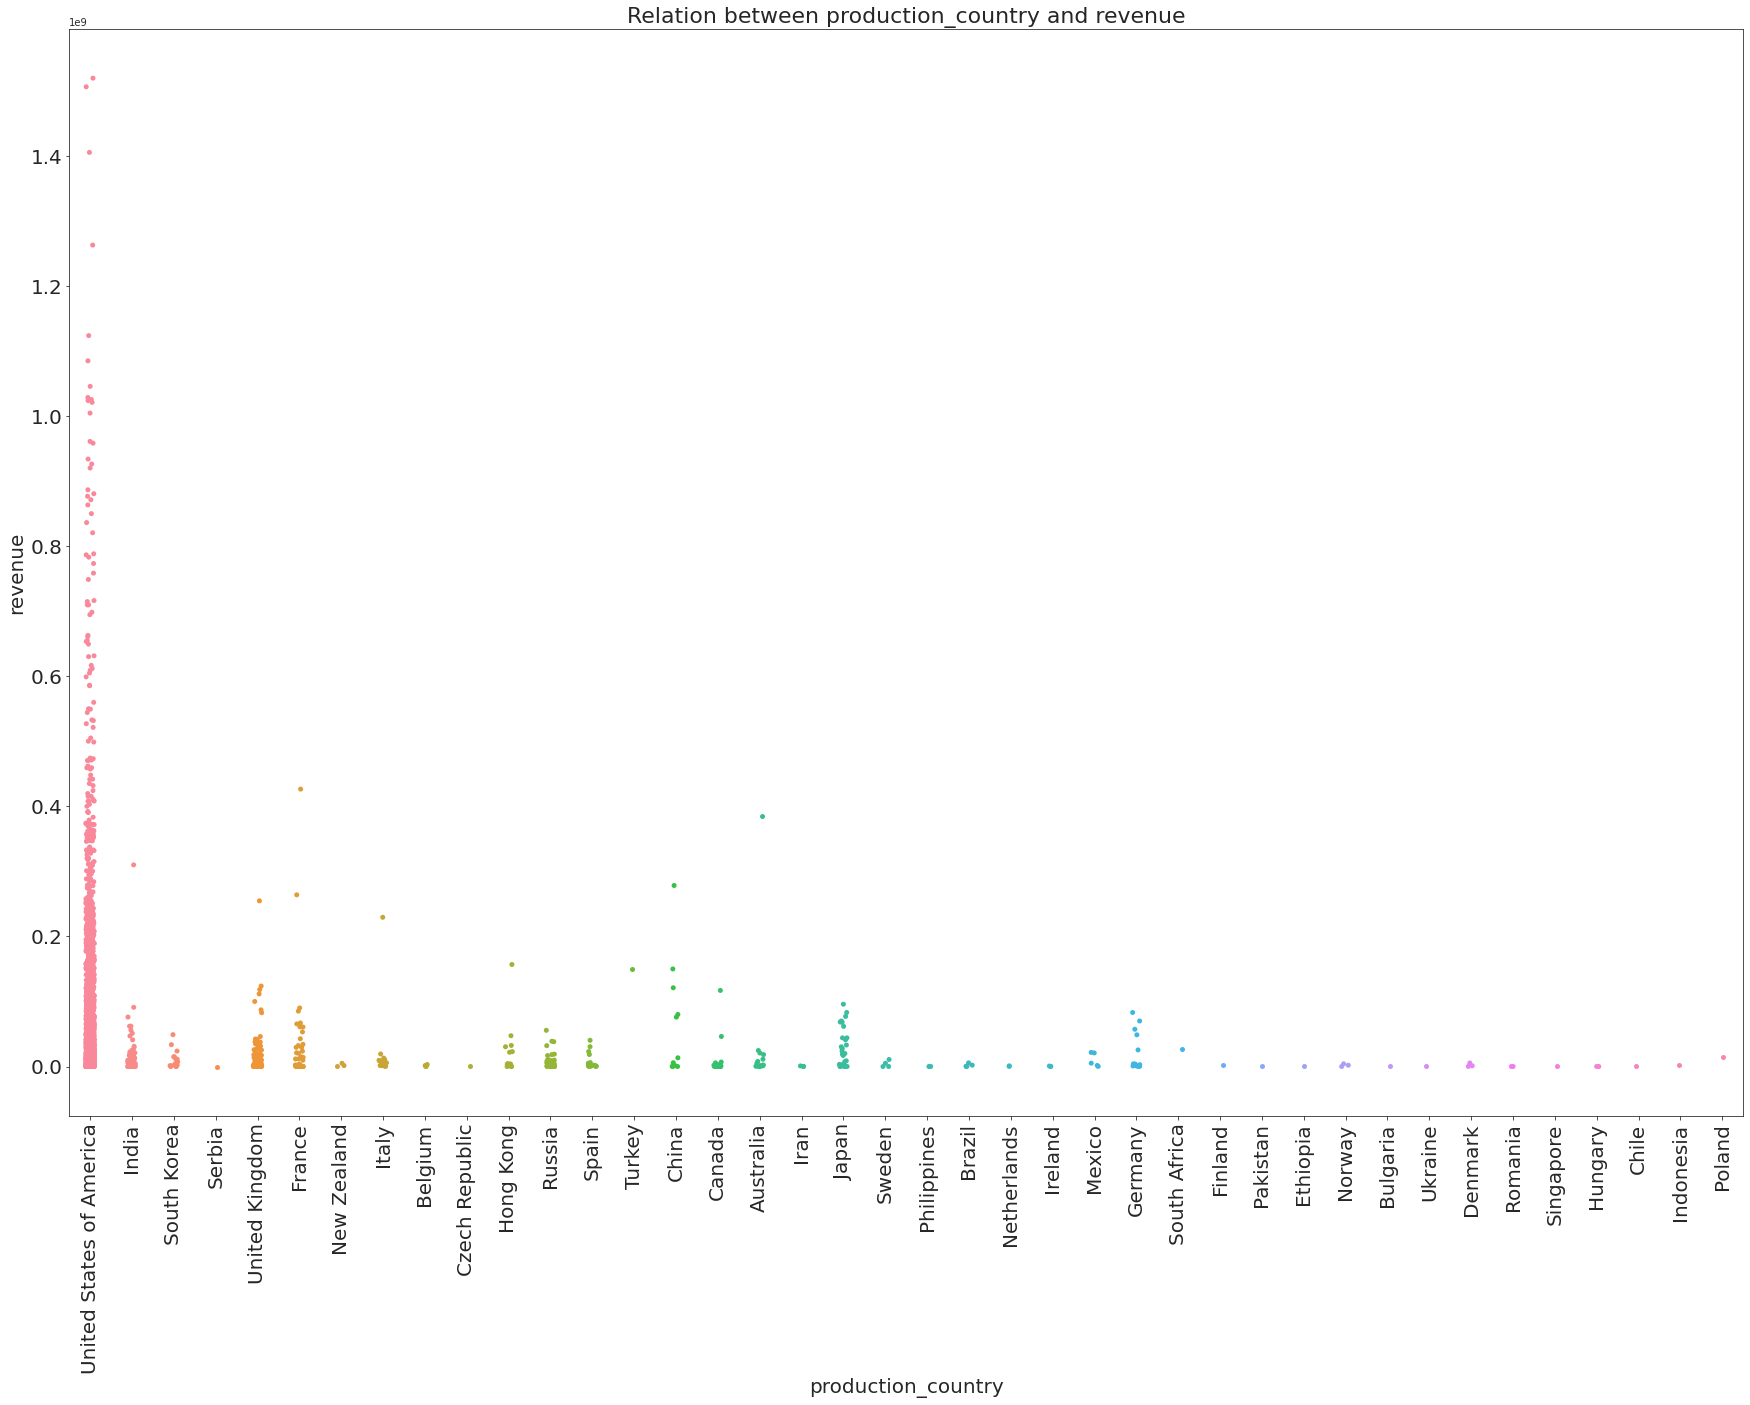

In [40]:
# Relation between 'production_country' and 'revenue'
_,axss = plt.subplots(1,1, figsize=[30,20])
sns.stripplot(x='production_country', y='revenue', data=train_df)
plt.title('Relation between production_country and revenue',fontsize=22)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.ylabel('revenue',fontsize=20)
plt.xlabel('production_country',fontsize=20)

In [41]:
j = 0
for i in train_df['production_country']:
    if i == 'United States of America':
        train_df['production_country'][j] = 'USA'
    elif i == np.NaN:
        train_df['production_country'][j] = np.NaN
    else:
        train_df['production_country'][j] = 'others'
    j += 1

In [42]:
train_df.production_country[:5]

0       USA
1       USA
2       USA
3    others
4    others
Name: production_country, dtype: object

## 3.8 release_date

In [43]:
train_df.release_date[:10]

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
5      8/6/87
6     8/30/12
7     1/15/04
8     2/16/96
9     4/16/03
Name: release_date, dtype: object

In [44]:
# Get the 'release_year'
train_df["release_year"] = train_df.release_date.apply(lambda x: int(x.split('/')[2]))
train_df.loc[((train_df["release_year"] <=19) & (train_df["release_year"] <100)), "release_year"] += 2000
train_df.loc[((train_df["release_year"] >19) & (train_df["release_year"] <100)), "release_year"] += 1900

train_df.sample(5)

,id,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,...,Romance,Science Fiction,TV Movie,Thriller,War,Western,original_title_len,num_production_companies,production_country,release_year
2344,2345,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,tt0454824,en,Flyboys,"The adventures of the Lafayette Escadrille, yo...",5.460942,/ap7UcuDPhyaY165YppEZJdbU1sA.jpg,...,1,0,0,0,1,0,7,4,USA,2006
128,129,18000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.sonypictures.com/homevideo/thefog/i...,tt0432291,en,The Fog,"Trapped within an eerie mist, the residents of...",9.929809,/qZ3Prt6jBvCWI08MsS9cPMM5lMi.jpg,...,0,0,0,1,0,0,7,2,others,2005
302,303,8000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,tt0368222,en,Romance & Cigarettes,Down-and-dirty musical love story set in the w...,2.365940,/hmePGWj7SFiDChBTfI9z8CY12sM.jpg,...,1,0,0,0,0,0,20,1,USA,2005
508,509,60000,"[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '...",http://www.pithemovie.com/,tt0138704,en,Pi,The debut film from Darren Aronofsky in which ...,10.621362,/d4pDorUHjIVFiVGiJar6sF2r8TQ.jpg,...,0,0,0,1,0,0,2,4,USA,1998
515,516,12000000,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",NaN,tt0164181,en,Stir of Echoes,"After being hypnotized by his sister in law, T...",5.875606,/pjdmvS3I5HElkJHzCNkqn5o8Kjf.jpg,...,0,0,0,1,0,0,14,1,USA,1999


<AxesSubplot:xlabel='release_year', ylabel='Density'>

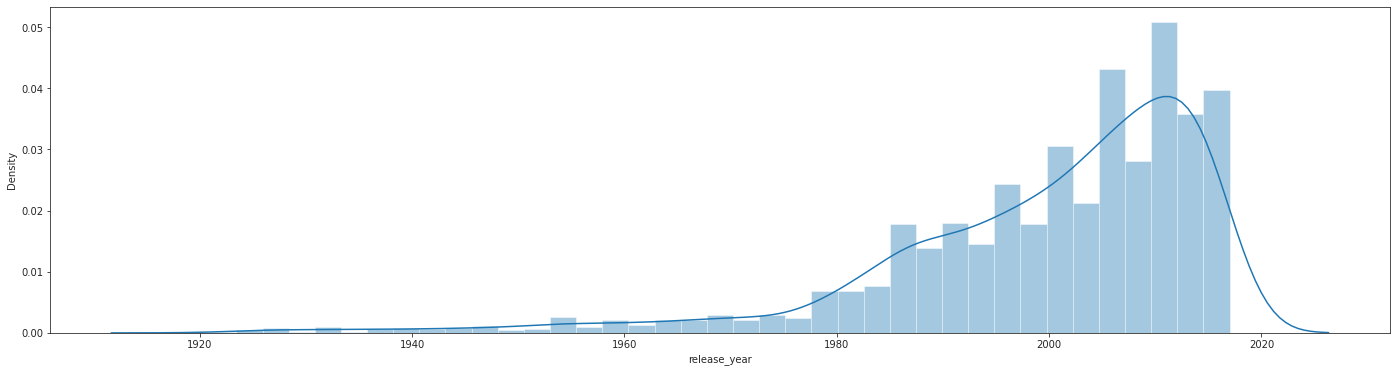

In [45]:
# Distribution of the 'release_year'
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(24,6)
sns.distplot(train_df.release_year)

Text(0.5, 0, 'release_year')

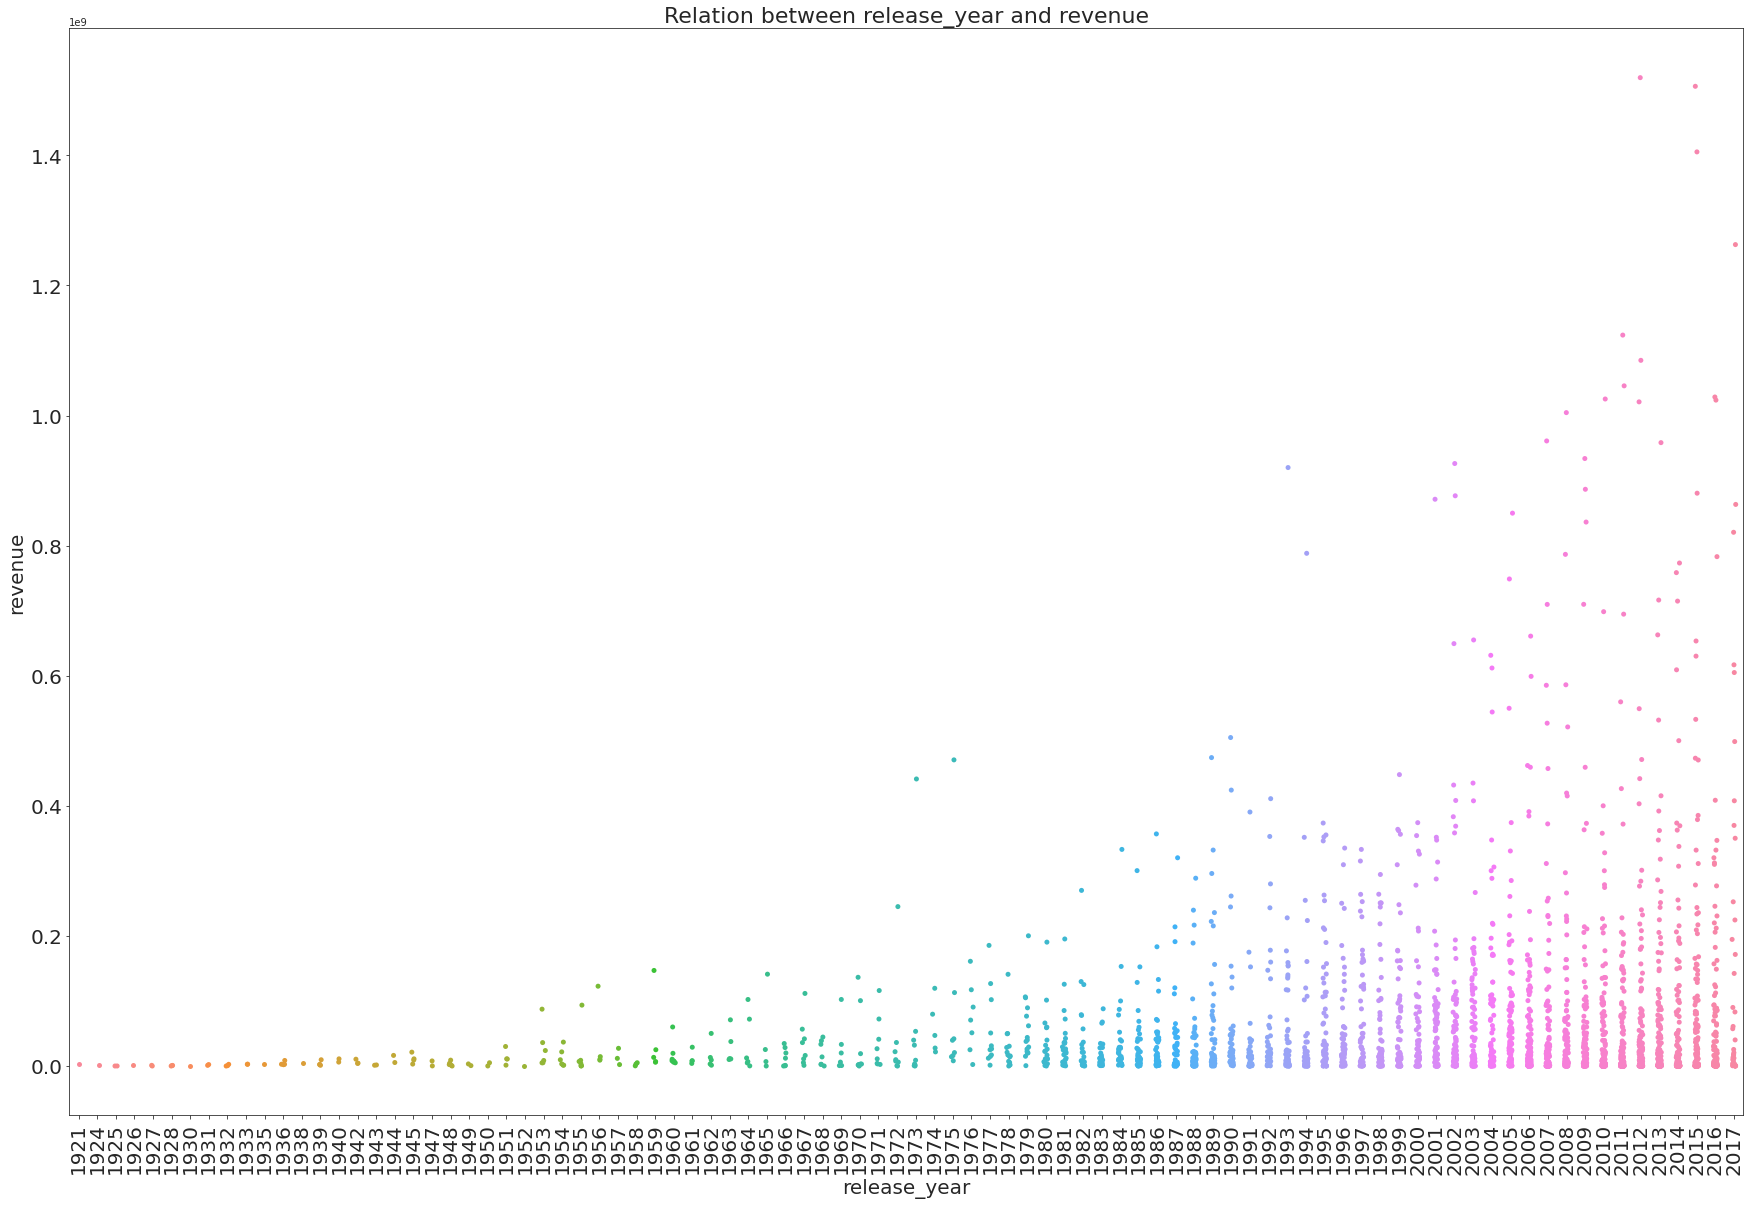

In [46]:
# Relation between 'release_year' and 'revenue'
_,axss = plt.subplots(1,1, figsize=[30,20])
sns.stripplot(x='release_year', y='revenue', data=train_df)
plt.title('Relation between release_year and revenue',fontsize=22)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.ylabel('revenue',fontsize=20)
plt.xlabel('release_year',fontsize=20)

In [47]:
# Get the 'release_month'
train_df["release_month"] = train_df.release_date.apply(lambda x: int(x.split('/')[0]))

Text(0.5, 1.0, 'Relation between release_month and revenue')

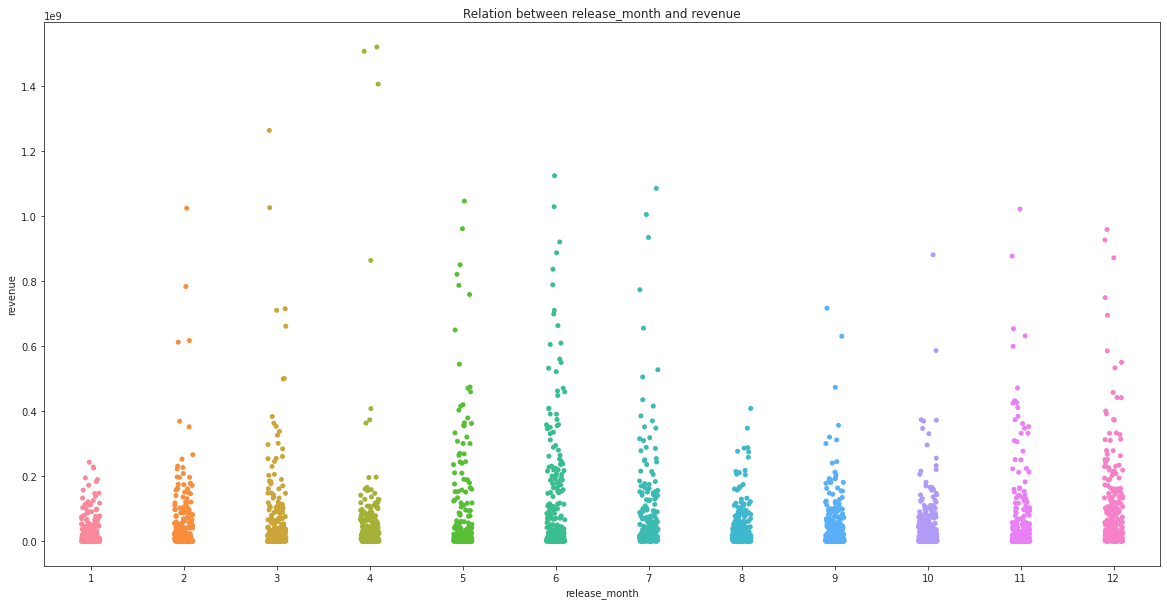

In [48]:
# Relation between 'release_month' and 'revenue'
_,axss = plt.subplots(1,1, figsize=[20,10])
sns.stripplot(x='release_month', y='revenue', data=train_df)
plt.title('Relation between release_month and revenue')

In [49]:
# Get the 'release_day'
train_df["release_day"] = train_df.release_date.apply(lambda x: int(x.split('/')[1]))

<AxesSubplot:title={'center':'Relation between release_day and revenue'}, xlabel='release_day', ylabel='revenue'>

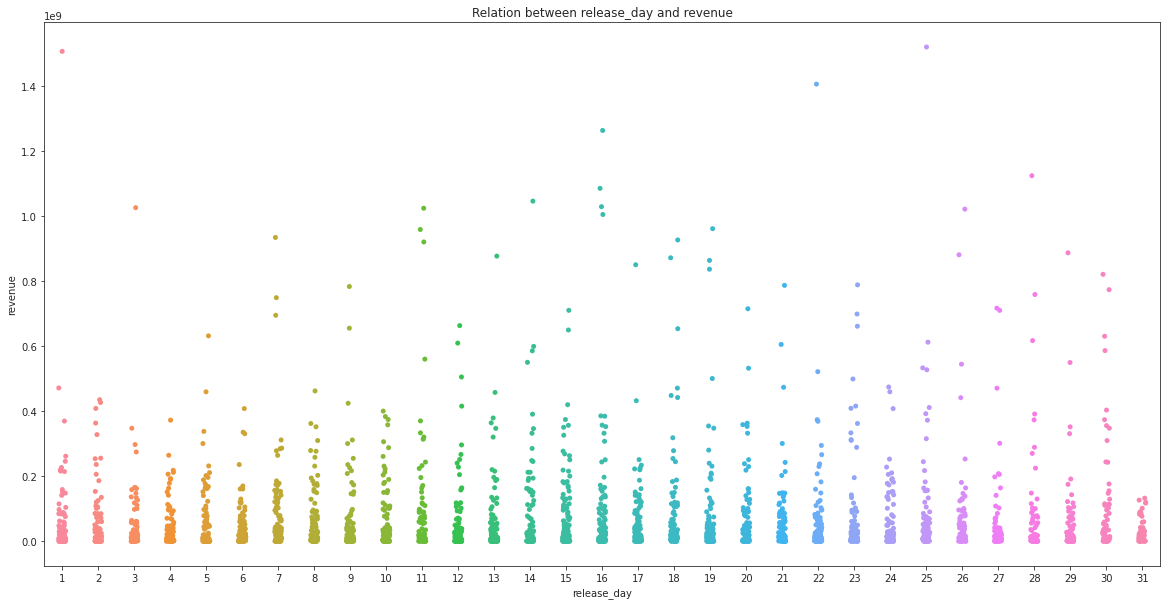

In [50]:
# Relation between 'release_day' and 'revenue'
_,axss = plt.subplots(1,1, figsize=[20,10])
plt.title('Relation between release_day and revenue')
sns.stripplot(x='release_day', y='revenue', data=train_df)

## 3.9 runtime

In [51]:
train_df.runtime[:10]

0     93.0
1    113.0
2    105.0
3    122.0
4    118.0
5     83.0
6     92.0
7     84.0
8    100.0
9     91.0
Name: runtime, dtype: float64

In [52]:
# The 'runtime' column contains 2 missing values. I replace them with the mean.
train_df.runtime = train_df.runtime.fillna(train_df.runtime.mean())

Text(0.5, 0, 'runtime')

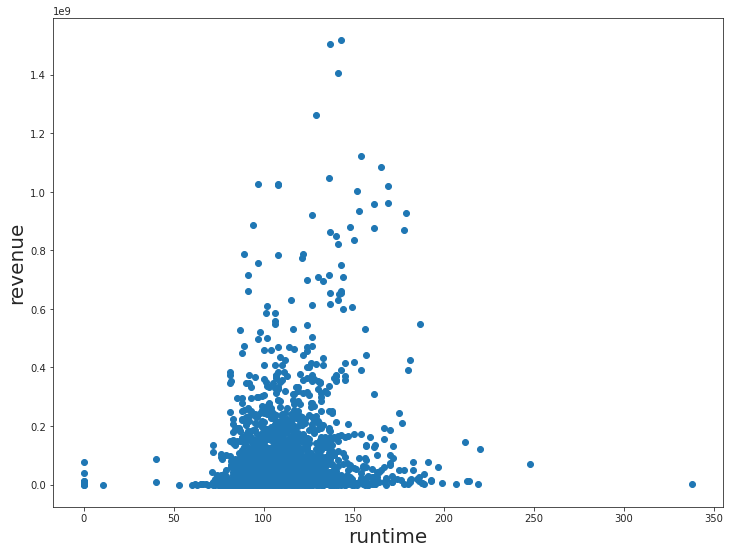

In [53]:
# Relation between 'runtime' and 'revenue'
plt.subplots(figsize=(12, 9))
plt.scatter(x=train_df['runtime'], y=train_df['revenue'])
plt.ylabel('revenue',fontsize=20)
plt.xlabel('runtime',fontsize=20)

## 3.10 spoken_languages

In [54]:
train_df.spoken_languages[:10]

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
5             [{'iso_639_1': 'en', 'name': 'English'}]
6             [{'iso_639_1': 'en', 'name': 'English'}]
7    [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...
8             [{'iso_639_1': 'en', 'name': 'English'}]
9             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, dtype: object

In [55]:
# The numbers of the 'spoken_languages' seems to have an impact
num_spoken_languages = pd.DataFrame(columns=['num_spoken_languages'])
train_df = pd.concat([train_df, num_spoken_languages], axis=1)

In [56]:
j = 0
for i in train_df['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        train_df['num_spoken_languages'][j] = len(d)
    else:
        train_df['num_spoken_languages'][j] = np.NaN
    j += 1

In [57]:
train_df.num_spoken_languages[:5]

0    1
1    1
2    1
3    2
4    1
Name: num_spoken_languages, dtype: object

Text(0.5, 0, 'num_spoken_languages')

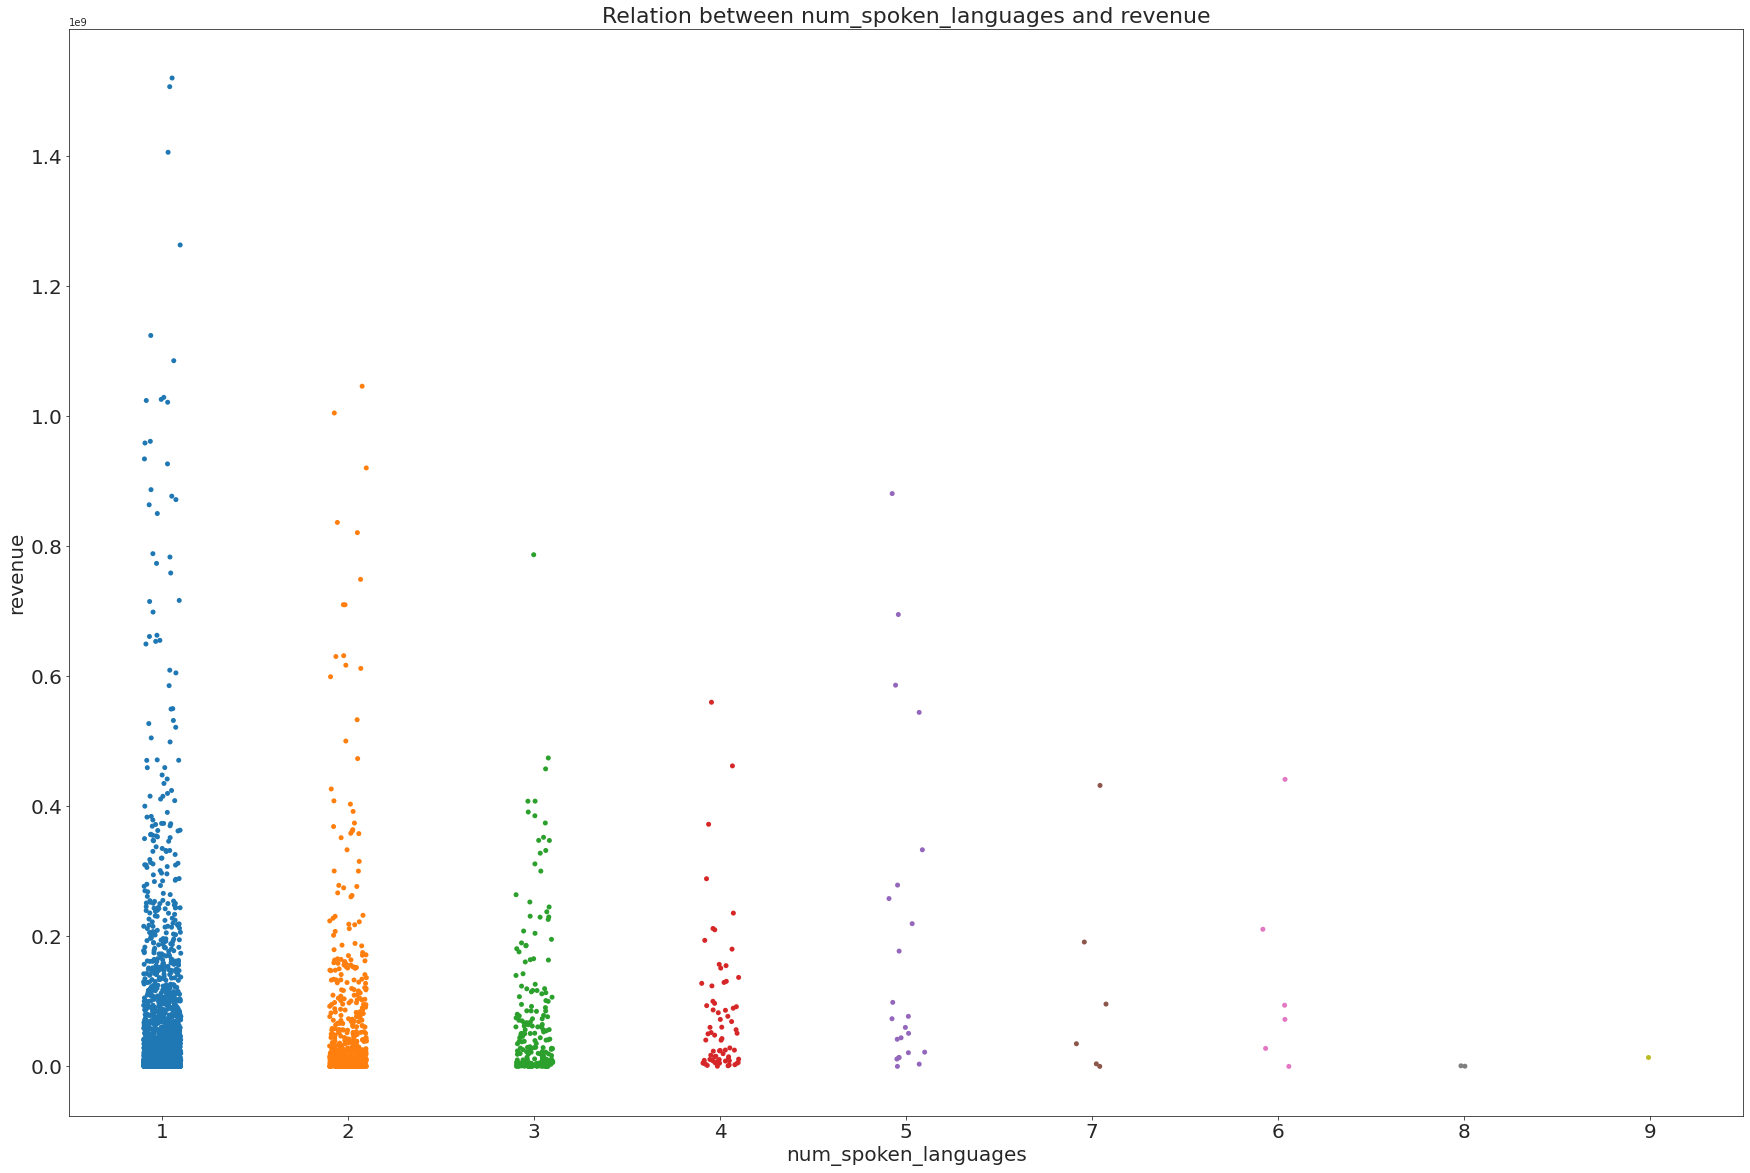

In [58]:
# Relation between 'num_spoken_languages' and 'revenue'
_,axss = plt.subplots(1,1, figsize=[30,20])
sns.stripplot(x='num_spoken_languages', y='revenue', data=train_df)
plt.title('Relation between num_spoken_languages and revenue',fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('revenue',fontsize=20)
plt.xlabel('num_spoken_languages',fontsize=20)

In [59]:
# We can also take a look at 'Is English a Spoken Language' and see if it has an impact
is_en_spoken = pd.DataFrame(columns=['is_en_spoken'])
train_df = pd.concat([train_df, is_en_spoken], axis=1)

In [60]:
j = 0
for i in train_df['spoken_languages']:
    d = get_dict(i)
    if d != {}:
        langs = []
        for k in range(len(d)):
            lang = d[k]['name']
            langs.append(lang)
        if 'English' in langs:
            train_df['is_en_spoken'][j] = 1
        else:
            train_df['is_en_spoken'][j] = 0
    else:
        train_df['is_en_spoken'][j] = -1
    j += 1

Text(0.5, 1.0, 'Relation between is_en_spoken and revenue')

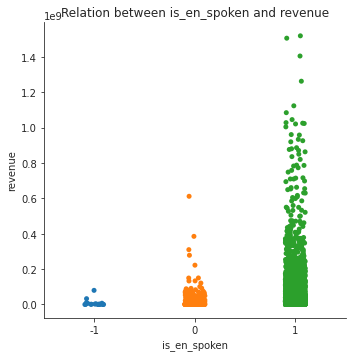

In [61]:
# Relation between 'is_en_spoken' and 'revenue'
sns.catplot(x='is_en_spoken', y='revenue', data=train_df)
plt.title('Relation between is_en_spoken and revenue')

## 3.11 status

In [62]:
train_df.status[:5]

0    Released
1    Released
2    Released
3    Released
4    Released
Name: status, dtype: object

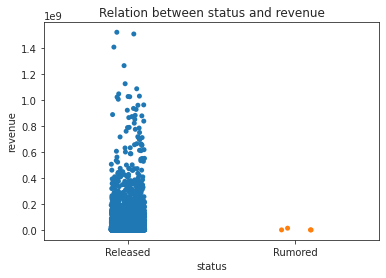

Released    2996
Rumored        4
Name: status, dtype: int64


In [63]:
# Relation between 'status' and 'revenue'
plt.title('Relation between status and revenue')
sns.stripplot(x='status', y='revenue', data=train_df,jitter=True)
plt.show()
print(train_df['status'].value_counts())

## 3.12 tagline

In [64]:
train_df.tagline[:10]

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
3                                                  NaN
4                                                  NaN
5                                                  NaN
6                 Fear The Demon That Doesn't Fear God
7                Different channels. Different truths.
8                          Set sail for Muppet mayhem!
9             Back together for the first time, again.
Name: tagline, dtype: object

In [65]:
# We can make it be a boolean value
train_df['tagline_boolean'] = train_df.tagline.isna()
set(train_df['tagline_boolean'])

{False, True}

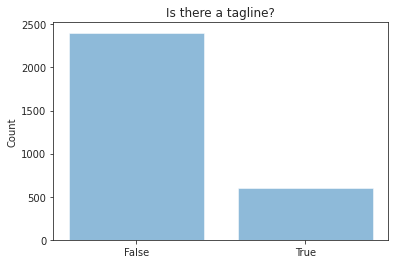

In [66]:
objects = set(train_df['tagline_boolean'])
y_pos = np.arange(len(objects))
performance = [((train_df['tagline_boolean'] == False).sum()), ((train_df['tagline_boolean']).sum())]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Is there a tagline?')

plt.show()

## 3.13 title

In [67]:
train_df.title[:10]

0                      Hot Tub Time Machine 2
1    The Princess Diaries 2: Royal Engagement
2                                    Whiplash
3                                     Kahaani
4                                  Marine Boy
5      Pinocchio and the Emperor of the Night
6                              The Possession
7                                Control Room
8                      Muppet Treasure Island
9                               A Mighty Wind
Name: title, dtype: object

In [68]:
# We can look into the 'sequel'
train_df["sequel"] = train_df.title.apply(lambda x: bool(re.search(r'\d', x)) )

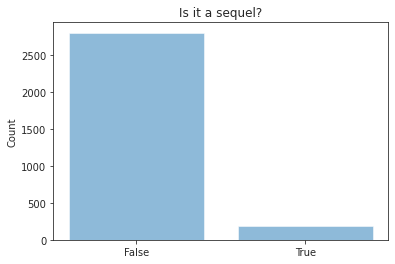

In [69]:
objects = set(train_df['sequel'])
y_pos = np.arange(len(objects))
performance = [((train_df['sequel'] == False).sum()), ((train_df['sequel']).sum())]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Is it a sequel?')

plt.show()

## 3.14 cast

In [70]:
for i in range(1):
    print(train_df['cast'][i])

[{'cast_id': 4, 'character': 'Lou', 'credit_id': '52fe4ee7c3a36847f82afae7', 'gender': 2, 'id': 52997, 'name': 'Rob Corddry', 'order': 0, 'profile_path': '/k2zJL0V1nEZuFT08xUdOd3ucfXz.jpg'}, {'cast_id': 5, 'character': 'Nick', 'credit_id': '52fe4ee7c3a36847f82afaeb', 'gender': 2, 'id': 64342, 'name': 'Craig Robinson', 'order': 1, 'profile_path': '/tVaRMkJXOEVhYxtnnFuhqW0Rjzz.jpg'}, {'cast_id': 6, 'character': 'Jacob', 'credit_id': '52fe4ee7c3a36847f82afaef', 'gender': 2, 'id': 54729, 'name': 'Clark Duke', 'order': 2, 'profile_path': '/oNzK0umwm5Wn0wyEbOy6TVJCSBn.jpg'}, {'cast_id': 7, 'character': 'Adam Jr.', 'credit_id': '52fe4ee7c3a36847f82afaf3', 'gender': 2, 'id': 36801, 'name': 'Adam Scott', 'order': 3, 'profile_path': '/5gb65xz8bzd42yjMAl4zwo4cvKw.jpg'}, {'cast_id': 8, 'character': 'Hot Tub Repairman', 'credit_id': '52fe4ee7c3a36847f82afaf7', 'gender': 2, 'id': 54812, 'name': 'Chevy Chase', 'order': 4, 'profile_path': '/svjpyYtPwtjvRxX9IZnOmOkhDOt.jpg'}, {'cast_id': 9, 'character'

In [71]:
# The number of the actors/the size of the cast might have an impact
size_of_cast = pd.DataFrame(columns=['size_of_cast'])
train_df = pd.concat([train_df, size_of_cast], axis=1)

In [72]:
j = 0
for i in train_df['cast']:
    d = get_dict(i)
    if d != {}:
        train_df['size_of_cast'][j] = len(d)
    else:
        train_df['size_of_cast'][j] = np.NaN
    j += 1

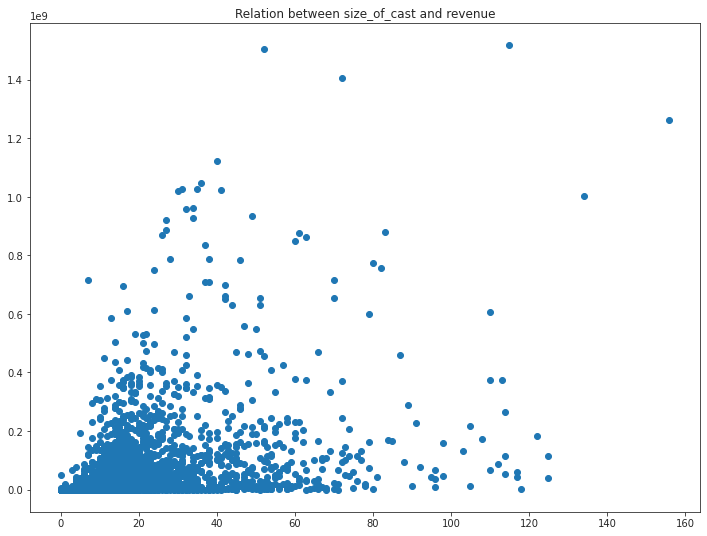

In [73]:
# Relation between 'size_of_cast' and 'revenue'
plt.subplots(figsize=(12, 9))
plt.title('Relation between size_of_cast and revenue')
plt.scatter(x=train_df['size_of_cast'], y=train_df['revenue'])

## 3.15 Drop unusable and duplicated features

In [74]:
train_df.columns

Index(['id', 'budget', 'genres', 'homepage', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue', 'genres_name', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'original_title_len', 'num_production_companies', 'production_country',
       'release_year', 'release_month', 'release_day', 'num_spoken_languages',
       'is_en_spoken', 'tagline_boolean', 'sequel', 'size_of_cast'],
      dtype='object')

In [75]:
drop_features = ['id','genres','genres_name','homepage','imdb_id','original_title','overview','poster_path','production_companies',
                           'production_countries','release_date','spoken_languages','tagline','title','Keywords','cast','crew']
new_train = train_df.drop(drop_features, axis=1)

In [76]:
new_train.head(3)

,budget,original_language,popularity,runtime,status,revenue,Action,Adventure,Animation,Comedy,...,num_production_companies,production_country,release_year,release_month,release_day,num_spoken_languages,is_en_spoken,tagline_boolean,sequel,size_of_cast
0,14000000,en,6.575393,93.0,Released,12314651,0,0,0,1,...,3,USA,2015,2,20,1,1,False,True,24
1,40000000,en,8.248895,113.0,Released,95149435,0,0,0,1,...,1,USA,2004,8,6,1,1,False,True,20
2,3300000,en,64.299990,105.0,Released,13092000,0,0,0,0,...,3,USA,2014,10,10,1,1,False,False,51


In [77]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 2999
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   budget                    3000 non-null   int64  
 1   original_language         3000 non-null   object 
 2   popularity                3000 non-null   float64
 3   runtime                   3000 non-null   float64
 4   status                    3000 non-null   object 
 5   revenue                   3000 non-null   int64  
 6   Action                    3000 non-null   int64  
 7   Adventure                 3000 non-null   int64  
 8   Animation                 3000 non-null   int64  
 9   Comedy                    3000 non-null   int64  
 10  Crime                     3000 non-null   int64  
 11  Documentary               3000 non-null   int64  
 12  Drama                     3000 non-null   int64  
 13  Family                    3000 non-null   int64  
 14  Fantasy      

## 3.16 Null values

In [78]:
new_train.isnull().sum()

budget                        0
original_language             0
popularity                    0
runtime                       0
status                        0
revenue                       0
Action                        0
Adventure                     0
Animation                     0
Comedy                        0
Crime                         0
Documentary                   0
Drama                         0
Family                        0
Fantasy                       0
Foreign                       0
History                       0
Horror                        0
Music                         0
Mystery                       0
Romance                       0
Science Fiction               0
TV Movie                      0
Thriller                      0
War                           0
Western                       0
original_title_len            0
num_production_companies    156
production_country            0
release_year                  0
release_month                 0
release_

### 3.16.1 Numerical features

In [79]:
new_train1=new_train.copy()
new_train1['num_production_companies']=new_train1['num_production_companies'].fillna(new_train1['num_production_companies'].mean())
new_train1['num_spoken_languages']=new_train1['num_spoken_languages'].fillna(new_train1['num_spoken_languages'].mean())
new_train1['size_of_cast']=new_train1['size_of_cast'].fillna(new_train1['size_of_cast'].mean())
print(new_train1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 2999
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   budget                    3000 non-null   int64  
 1   original_language         3000 non-null   object 
 2   popularity                3000 non-null   float64
 3   runtime                   3000 non-null   float64
 4   status                    3000 non-null   object 
 5   revenue                   3000 non-null   int64  
 6   Action                    3000 non-null   int64  
 7   Adventure                 3000 non-null   int64  
 8   Animation                 3000 non-null   int64  
 9   Comedy                    3000 non-null   int64  
 10  Crime                     3000 non-null   int64  
 11  Documentary               3000 non-null   int64  
 12  Drama                     3000 non-null   int64  
 13  Family                    3000 non-null   int64  
 14  Fantasy      

### 3.16.2 Categorical features

In [80]:
new_train1 = new_train1.fillna(-1)

In [81]:
# Mapping original_language
new_train1['original_language'] = new_train1['original_language'].map({'others': 0, 'en': 1}).astype(int)
    
# Mapping status
new_train1['status'] = new_train1['status'].map( {'Rumored': 0, 'Released': 1} ).astype(int)
    
# Mapping production_country
new_train1['production_country'] = new_train1['production_country'].map( {'others': 2, 'USA': 1} ).astype(int)
    
# Mapping tagline_boolean
new_train1['tagline_boolean'] = new_train1['tagline_boolean'].astype(int)
    
# Mapping sequel
new_train1['sequel'] = new_train1['sequel'].astype(int)

In [82]:
new_train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 2999
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   budget                    3000 non-null   int64  
 1   original_language         3000 non-null   int64  
 2   popularity                3000 non-null   float64
 3   runtime                   3000 non-null   float64
 4   status                    3000 non-null   int64  
 5   revenue                   3000 non-null   int64  
 6   Action                    3000 non-null   int64  
 7   Adventure                 3000 non-null   int64  
 8   Animation                 3000 non-null   int64  
 9   Comedy                    3000 non-null   int64  
 10  Crime                     3000 non-null   int64  
 11  Documentary               3000 non-null   int64  
 12  Drama                     3000 non-null   int64  
 13  Family                    3000 non-null   int64  
 14  Fantasy      

In [83]:
new_train1.head(3)

,budget,original_language,popularity,runtime,status,revenue,Action,Adventure,Animation,Comedy,...,num_production_companies,production_country,release_year,release_month,release_day,num_spoken_languages,is_en_spoken,tagline_boolean,sequel,size_of_cast
0,14000000,1,6.575393,93.0,1,12314651,0,0,0,1,...,3.0,1,2015,2,20,1.0,1,0,1,24.0
1,40000000,1,8.248895,113.0,1,95149435,0,0,0,1,...,1.0,1,2004,8,6,1.0,1,0,1,20.0
2,3300000,1,64.299990,105.0,1,13092000,0,0,0,0,...,3.0,1,2014,10,10,1.0,1,0,0,51.0


# 4 Data scaling and spliting
## 4.1 Pearson Correlation

In [84]:
new_train1.columns

Index(['budget', 'original_language', 'popularity', 'runtime', 'status',
       'revenue', 'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History',
       'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie',
       'Thriller', 'War', 'Western', 'original_title_len',
       'num_production_companies', 'production_country', 'release_year',
       'release_month', 'release_day', 'num_spoken_languages', 'is_en_spoken',
       'tagline_boolean', 'sequel', 'size_of_cast'],
      dtype='object')

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

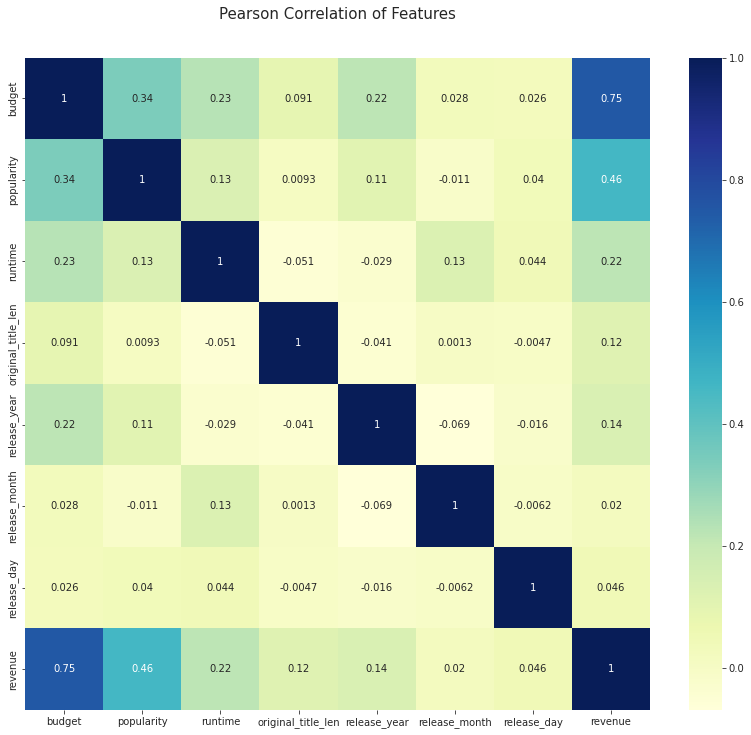

In [85]:
# Correlation among the selected numerical features
numerical_features = ['budget', 'original_language', 'popularity', 'runtime', 'original_title_len', 
                      'num_production_companies', 'release_year', 'release_month', 'release_day', 
                      'num_spoken_languages', 'size_of_cast','revenue']
corr = train_df[numerical_features].corr() 

plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(corr, cmap="YlGnBu",annot=True)

## 4.2 Standardization

In [86]:
scale_lst = numerical_features
new_train_sc = new_train1.copy()

sc_scale = preprocessing.StandardScaler().fit(new_train_sc[scale_lst])
new_train_sc[scale_lst] = sc_scale.transform(new_train_sc[scale_lst])
new_train_sc.head()

,budget,original_language,popularity,runtime,status,revenue,Action,Adventure,Animation,Comedy,...,num_production_companies,production_country,release_year,release_month,release_day,num_spoken_languages,is_en_spoken,tagline_boolean,sequel,size_of_cast
0,-0.298337,0.406262,-0.155998,-0.672993,1,-0.395691,0,0,0,1,...,8.036217e-02,1,0.991327,-1.400988,0.573903,-0.525373,1,0,1,0.199543
1,0.426820,0.406262,-0.017714,0.232994,1,0.206703,0,0,0,1,...,-9.656334e-01,1,0.278002,0.359293,-1.048055,-0.525373,1,0,1,-0.041840
2,-0.596767,0.406262,4.613849,-0.129401,1,-0.390038,0,0,0,0,...,8.036217e-02,1,0.926479,0.946053,-0.584639,-0.525373,1,0,0,1.828874
3,-0.655337,-2.461468,-0.436981,0.640688,1,-0.368890,0,0,0,0,...,2.322577e-16,2,0.796784,-1.107608,-0.700493,0.611599,1,1,0,-0.826333
4,-0.465681,-2.461468,-0.604463,0.459490,1,-0.456710,1,0,0,0,...,2.322577e-16,2,0.602241,-1.400988,-1.163909,-0.525373,0,1,0,-1.007370


## 4.3 Dataset spliting

In [87]:
train, validate = train_test_split(new_train_sc, test_size=0.15, random_state = 3)
model_train_x = train.drop(['revenue'], axis = 1)
model_validate_x = validate.drop(['revenue'], axis = 1)
model_train_y = train['revenue']
model_validate_y = validate['revenue']

In [88]:
model_train_x.head(5)

,budget,original_language,popularity,runtime,status,Action,Adventure,Animation,Comedy,Crime,...,num_production_companies,production_country,release_year,release_month,release_day,num_spoken_languages,is_en_spoken,tagline_boolean,sequel,size_of_cast
2803,-0.465681,0.406262,-0.439145,-0.808890,1,1,1,0,0,0,...,2.172353,1,0.148307,0.065913,1.269028,-0.525373,1,0,0,-0.403914
1902,1.542445,0.406262,0.239177,0.097096,1,1,0,0,1,0,...,2.695351,1,0.537393,-0.227467,0.458049,0.611599,1,0,0,2.251294
1210,0.761507,0.406262,-0.128667,0.187694,1,0,0,0,1,0,...,0.603360,1,0.731936,0.359293,-1.163909,-0.525373,1,0,0,-0.102186
1927,0.047507,-2.461468,-0.341504,2.135565,1,1,0,0,1,0,...,-0.965633,2,0.667089,0.946053,-1.627326,1.748571,1,1,0,-0.464259
2340,0.147913,0.406262,0.299760,0.097096,1,0,0,0,1,0,...,-0.442636,1,-0.240780,0.065913,0.342195,-0.525373,1,0,0,-0.283222


In [89]:
model_train_y.head(5)

2803   -0.244662
1902    1.192352
1210    0.063447
1927   -0.034367
2340   -0.271739
Name: revenue, dtype: float64

# 5 Model Training - Stochastic Gradient Descent, Random Foreset and XGBoost (I haven't tuned the hyperparameters because running out of time)

In [90]:
# Stochastic Gradient Descent
model_SGD = SGDRegressor()

# Random Forest
model_RF = RandomForestRegressor()

# XGBoost
model_XGB = XGBRegressor()

In [91]:
# Train the model
model_SGD.fit(model_train_x, model_train_y)

SGDRegressor()

In [92]:
# Prediction of test data
model_SGD.predict(model_validate_x)

array([-5.38169468e-01, -9.43259766e-03, -2.72252754e-01, -5.91006321e-01,
       -3.87865562e-01, -1.58343687e-01, -2.53940385e-01,  6.07845795e-01,
       -4.36663875e-01,  1.19814647e-01, -7.11765817e-01,  7.96769915e-01,
        5.33905443e-01, -4.07500364e-01,  6.06502638e-01, -3.25874713e-01,
       -5.52181979e-01,  9.20798846e-01,  1.17490157e-01, -2.41100110e-01,
       -5.64990000e-01, -6.19170902e-01, -4.15002977e-01, -7.38999584e-01,
        1.82091136e-01, -4.65154006e-01,  3.39998806e-01, -4.80483471e-01,
       -5.73309513e-01, -5.16090538e-01,  6.44371831e-01, -5.13516441e-01,
        9.91193446e-01, -4.59866734e-01, -3.65528302e-01, -5.27543046e-01,
       -4.90139918e-01, -3.67572144e-01,  7.88168096e-01, -4.95552888e-01,
        6.69888659e-01, -3.16425843e-01,  2.75087258e-01,  3.27709732e-01,
       -6.52356845e-01,  2.02635042e-01,  7.43539661e-01, -2.46616080e-01,
       -6.84324791e-01, -3.96851013e-01, -4.24473621e-01, -3.97523831e-01,
        1.22117055e-01, -

In [93]:
# Accuracy of test data
model_SGD.score(model_validate_x, model_validate_y)

0.5727820570884831

In [94]:
# Use 5-fold Cross Validation to get the accuracy for different models
model_names = ['SGD','Random Forest','XGBoost']
model_list = [model_SGD, model_RF, model_XGB]
count = 0

for model in model_list:
    cv_score = model_selection.cross_val_score(model, model_train_x, model_train_y, cv=5)
    print(cv_score)
    print('Model accuracy of ' + model_names[count] + ' is ' + str(cv_score.mean()))
    count += 1

[0.61612315 0.65840888 0.59284338 0.71124751 0.55741293]
Model accuracy of SGD is 0.6272071722358386
[0.70234344 0.66279503 0.67767326 0.74678    0.61139457]
Model accuracy of Random Forest is 0.6801972613762183
[0.67703938 0.6311006  0.60513757 0.71834978 0.53160615]
Model accuracy of XGBoost is 0.6326466947957963


## 5.2 Use Grid Search to Find Optimal Hyperparameters (will continue to work on this part)

In [95]:
# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

### 5.2.1 SGD (will continue to work on this)

### 5.2.2 Random Forest

In [96]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [60,80,100],
    'max_depth': [1,5,10]
}
Grid_RF = GridSearchCV(RandomForestRegressor(),parameters, cv=5)
Grid_RF.fit(model_train_x, model_train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [60, 80, 100]})

In [97]:
# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.6785330480160392
Best parameters set:
max_depth:10
n_estimators:80


In [98]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

In [99]:
best_RF_model

RandomForestRegressor(max_depth=10, n_estimators=80)

### 5.2.3 XGBoost (will continue to work on this)

# 6 Model Evaluation
## 6.1 Evaluate all models

In [100]:
#For SGD
model_SGD.fit(model_train_x, model_train_y)
pred_y=model_SGD.predict(model_validate_x)
SGD_score=model_SGD.score(model_validate_x, model_validate_y)
MSE_SGD=mean_squared_error(model_validate_y,pred_y)
RMSE_SGD=np.sqrt(MSE_SGD)
print ('SGD score: ', SGD_score)
print ('Mean square error of SGD: ', MSE_SGD)
print ('Root mean squared error of SGD:', RMSE_SGD)

SGD score:  0.56805212735712
Mean square error of SGD:  0.39477259959400113
Root mean squared error of SGD: 0.6283093184045587


In [101]:
#For RF
model_RF.fit(model_train_x, model_train_y)
pred_y=model_RF.predict(model_validate_x)
RF_score=model_RF.score(model_validate_x, model_validate_y)
MSE_RF=mean_squared_error(model_validate_y,pred_y)
RMSE_RF=np.sqrt(MSE_RF)
print ('RF score: ', RF_score)
print ('Mean square error of RF: ', MSE_RF)
print ('Root mean squared error of RF:', RMSE_RF)

RF score:  0.5620601492359425
Mean square error of RF:  0.40024888256568114
Root mean squared error of RF: 0.6326522603813892


In [102]:
#For XGBoost
model_XGB.fit(model_train_x, model_train_y)
pred_y=model_XGB.predict(model_validate_x)
XGB_score=model_XGB.score(model_validate_x, model_validate_y)
MSE_XGB=mean_squared_error(model_validate_y,pred_y)
RMSE_XGB=np.sqrt(MSE_XGB)
print ('XGB score: ', XGB_score)
print ('Mean square error of XGB: ', MSE_XGB)
print ('Root mean squared error of XGB:', RMSE_XGB)

XGB score:  0.34047829996562473
Mean square error of XGB:  0.6027604544460464
Root mean squared error of XGB: 0.7763764901425381


## 6.2 Model Comparison

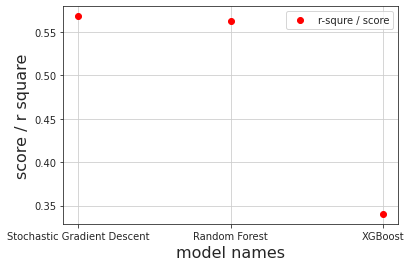

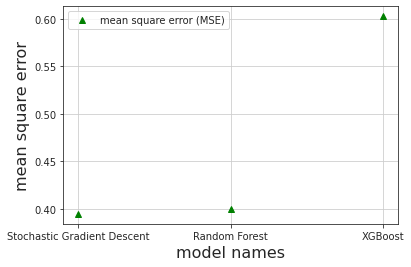

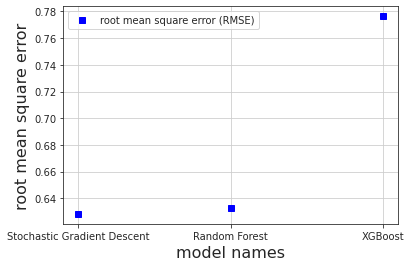

In [103]:
lst_score = [SGD_score, RF_score, XGB_score]
MSE_lst =  [MSE_SGD, MSE_RF, MSE_XGB]
RMSE_lst =  [RMSE_SGD, RMSE_RF, RMSE_XGB]
model_lst = ['Stochastic Gradient Descent', 'Random Forest', 'XGBoost']

plt.figure(1)
plt.plot(model_lst, lst_score, 'ro')
plt.legend(['r-squre / score'])
plt.xlabel('model names',fontsize =16)
plt.ylabel('score / r square', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(2)
plt.plot(model_lst, MSE_lst, 'g^')
plt.legend(['mean square error (MSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('mean square error', fontsize =16)
plt.grid(True)
plt.show()

plt.figure(3)
plt.plot(model_lst, RMSE_lst, 'bs')
plt.legend(['root mean square error (RMSE)'])
plt.xlabel('model names', fontsize =16)
plt.ylabel('root mean square error', fontsize =16)
plt.grid(True)
plt.show()

# 7 Conclusion
### According to MSE, RMSE and R square, Stochastic Gradient Descent model and Random Forest model have better performances. I will continue to work on the hyperparameter tuning, which might has an impact on the performance of the selected models. In addition, the data in the test.csv file needs to be cleaned and matched the selected features after doing feature engineering in order to make a prediction based on the best model.